2D Function Generation

32/32 [==============================] - 0s 2ms/step
Discriminator Accuracy Real: 71.60%, Fake: 38.80%
Generator Accuracy: 59.10%
4/4 [==============================] - 0s 7ms/step


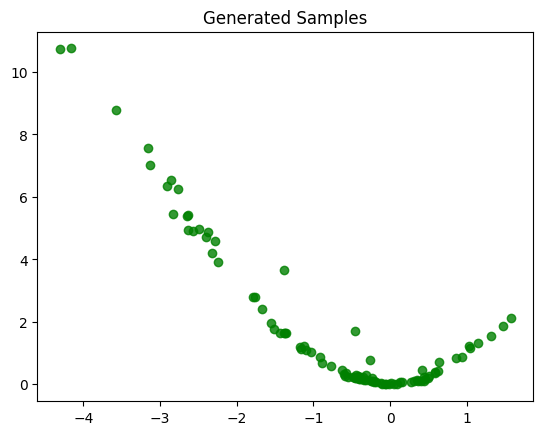

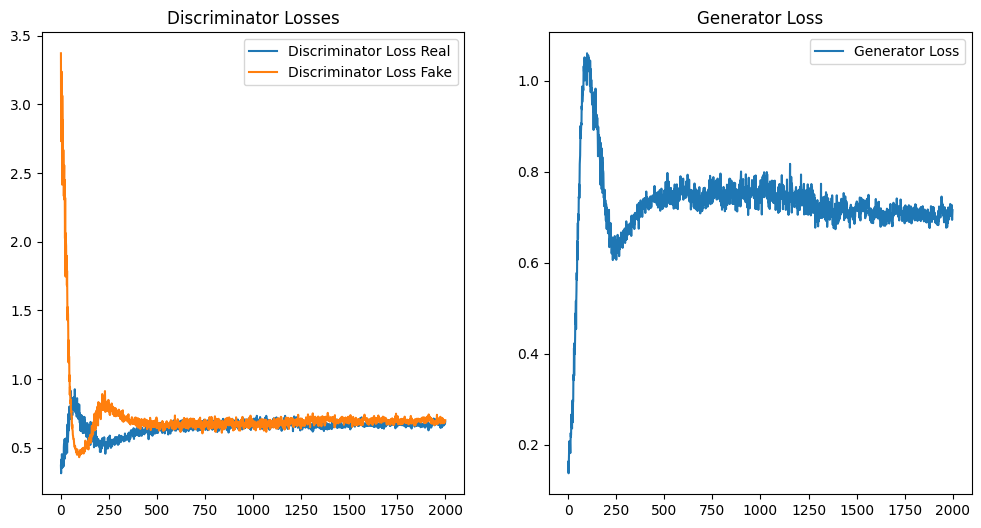

32/32 [==============================] - 0s 2ms/step
Discriminator Accuracy Real: 35.10%, Fake: 50.10%
Generator Accuracy: 50.00%
4/4 [==============================] - 0s 3ms/step


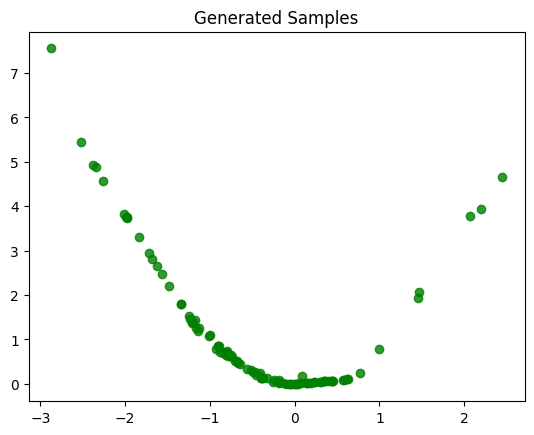

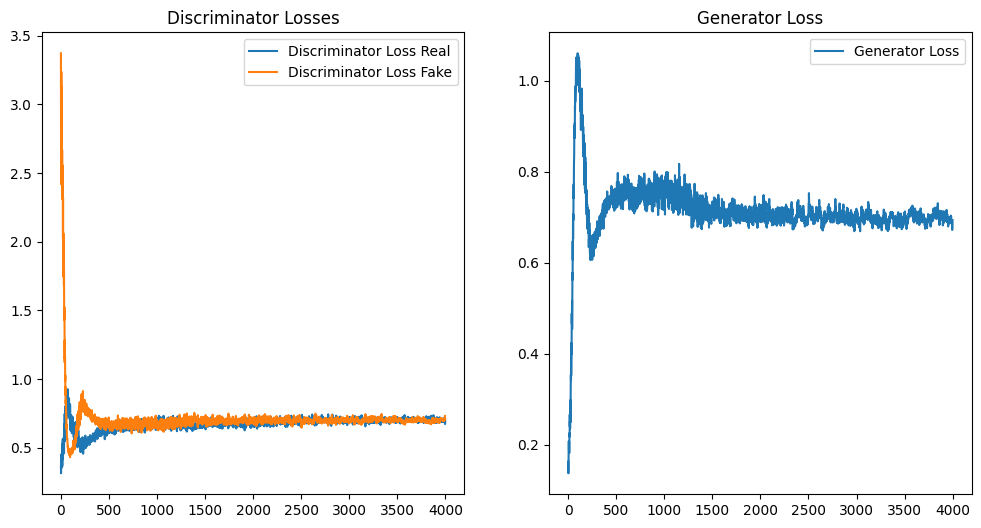

32/32 [==============================] - 0s 2ms/step
Discriminator Accuracy Real: 71.00%, Fake: 29.80%
Generator Accuracy: 69.80%
4/4 [==============================] - 0s 3ms/step


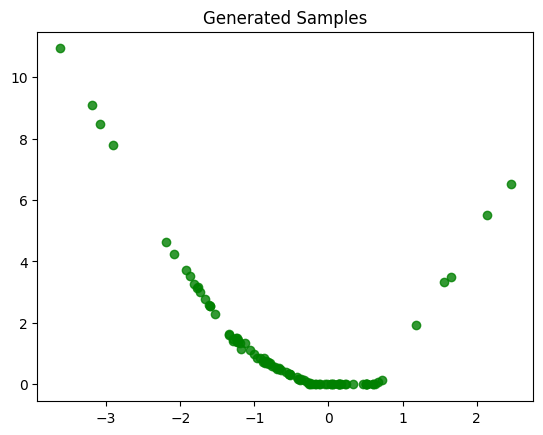

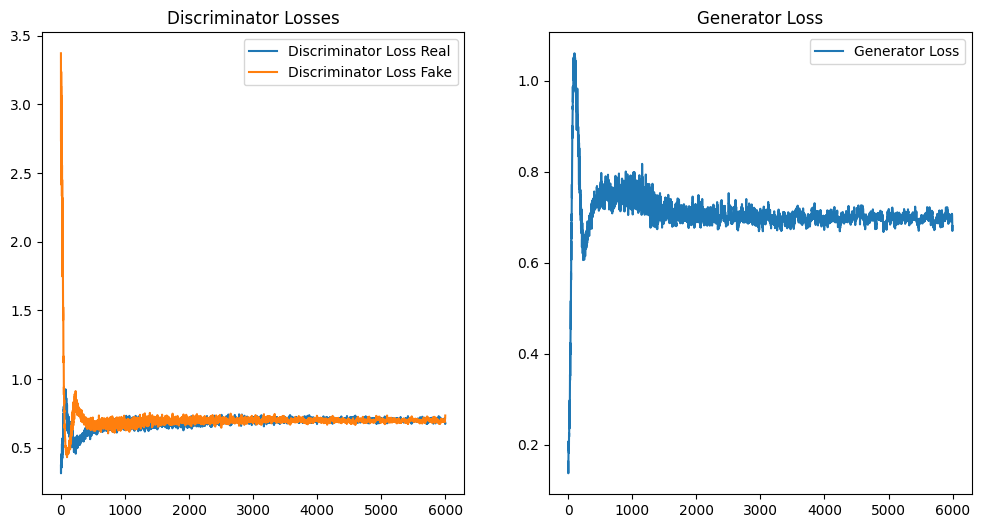

32/32 [==============================] - 0s 3ms/step
Discriminator Accuracy Real: 56.10%, Fake: 52.00%
Generator Accuracy: 49.30%
4/4 [==============================] - 0s 3ms/step


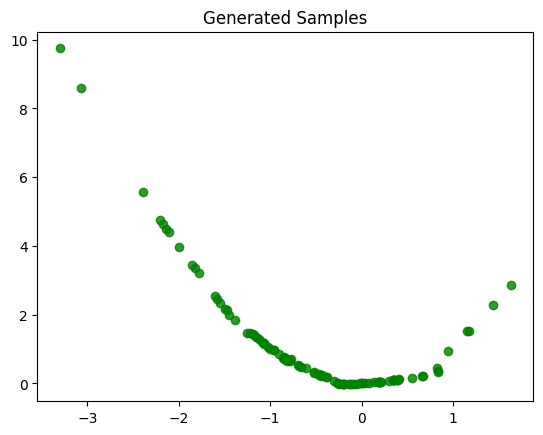

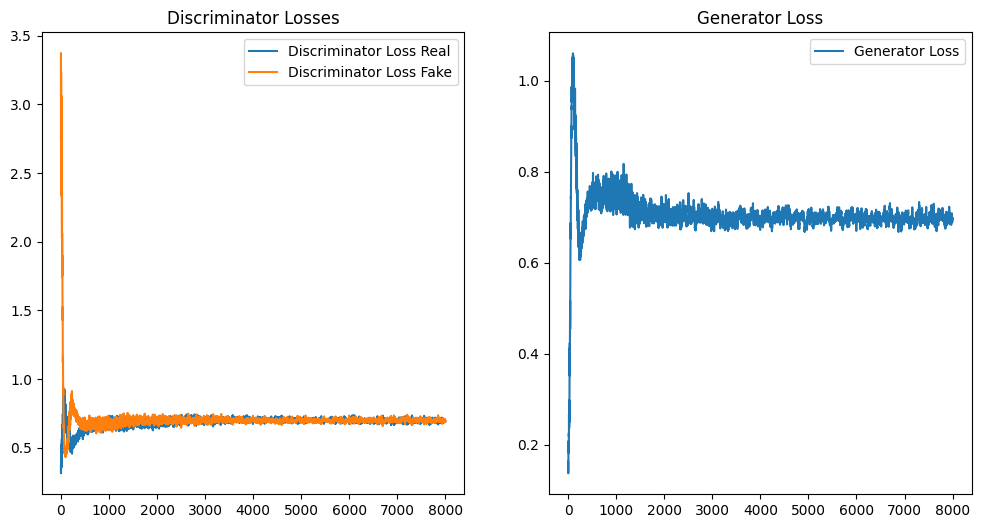

32/32 [==============================] - 0s 2ms/step
Discriminator Accuracy Real: 25.10%, Fake: 79.40%
Generator Accuracy: 16.70%
4/4 [==============================] - 0s 3ms/step


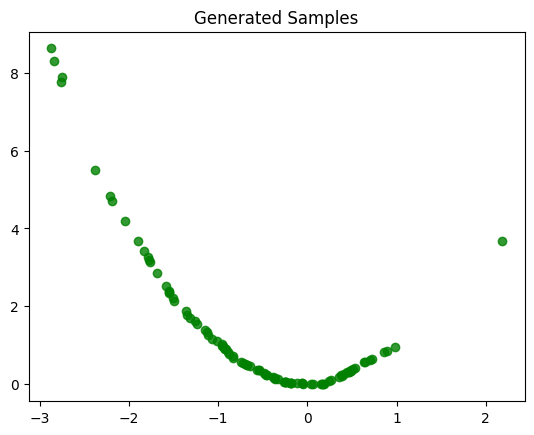

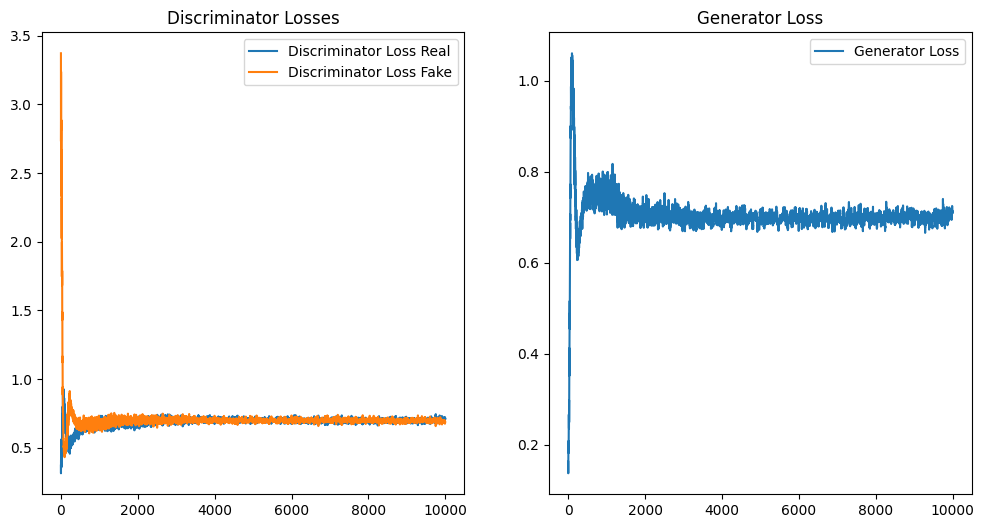

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


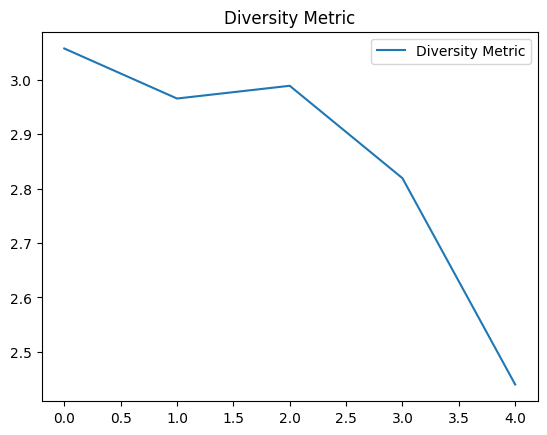

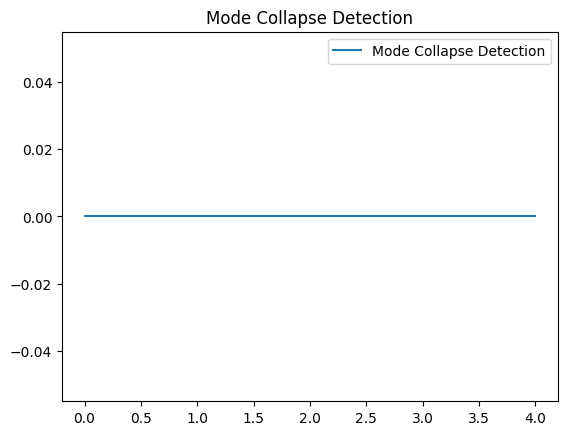

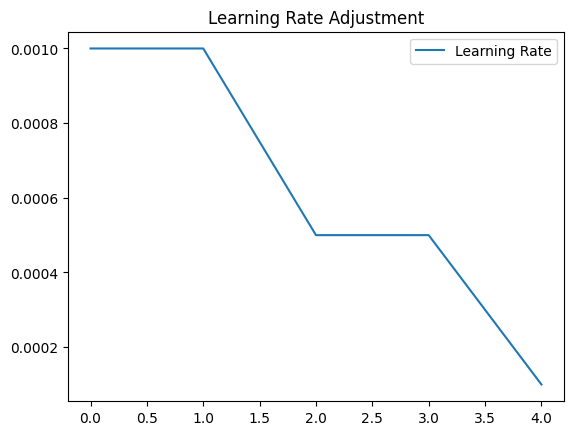

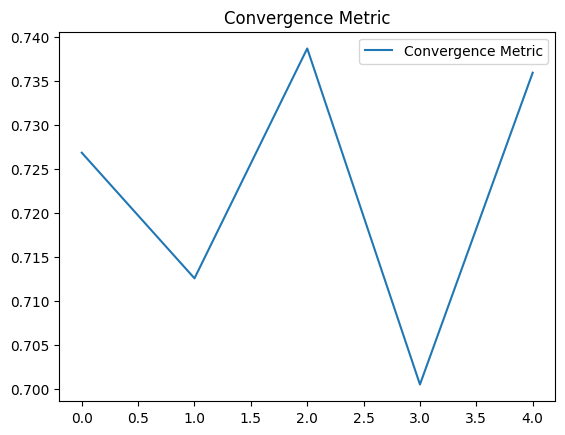

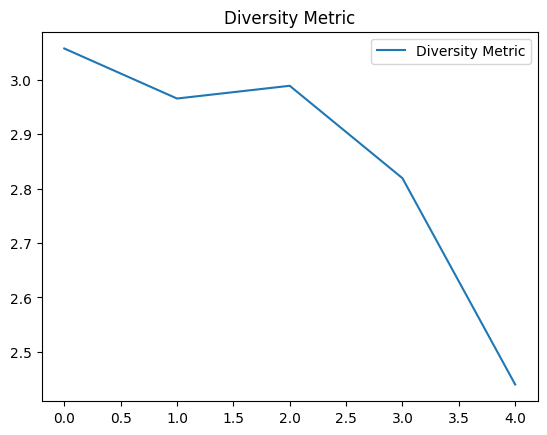

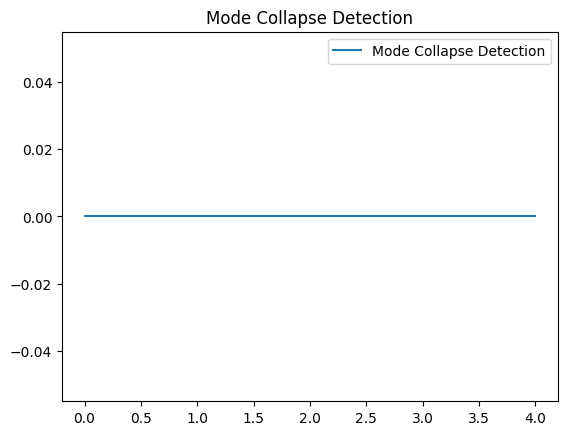

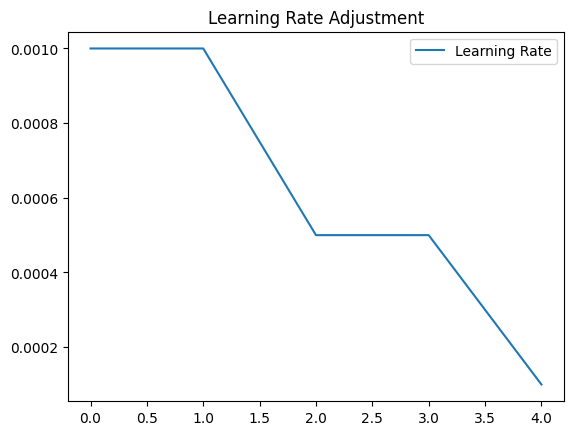

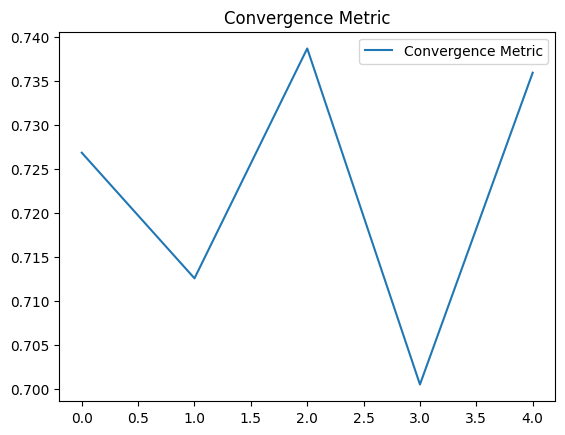

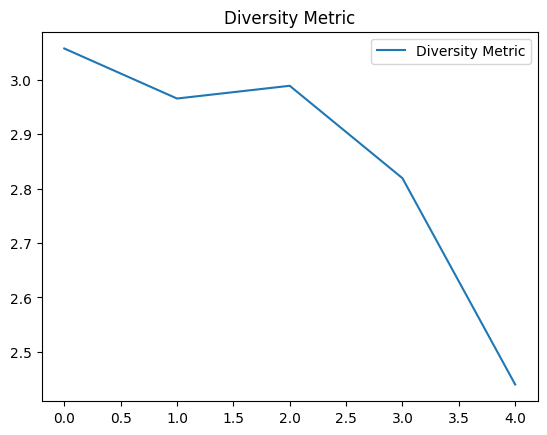

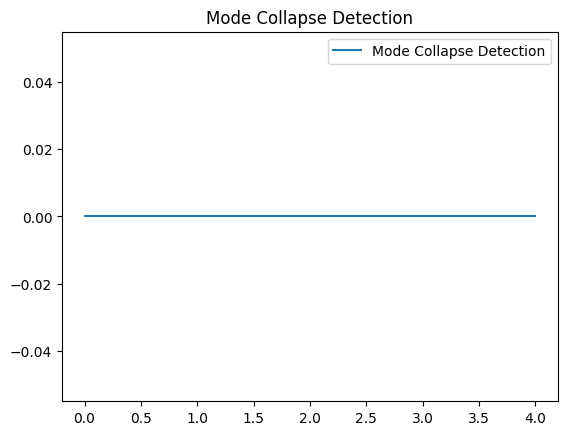

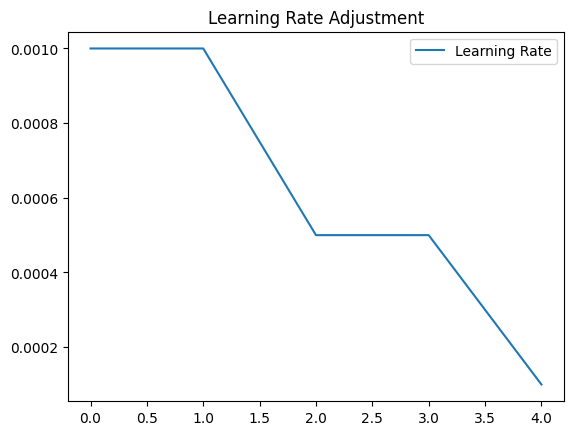

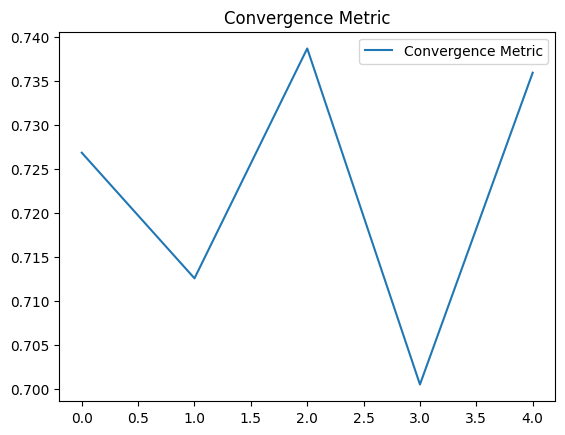

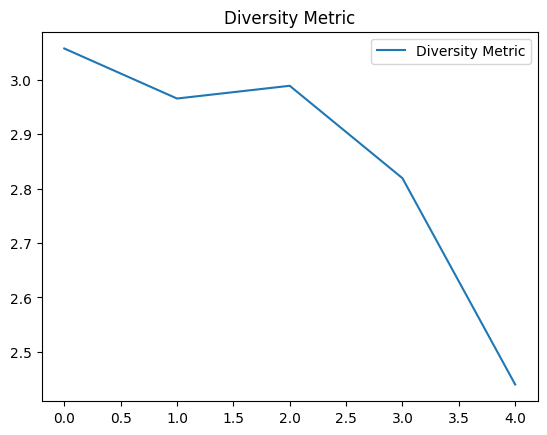

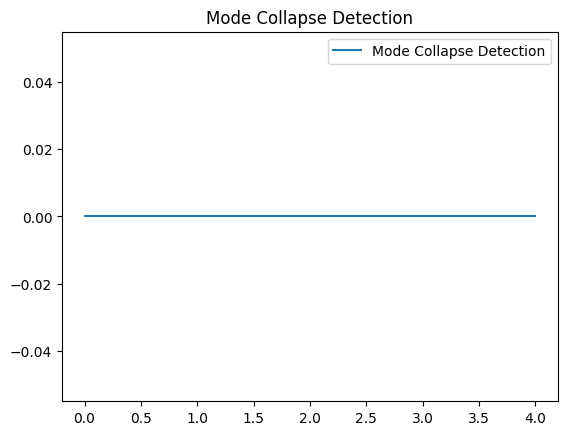

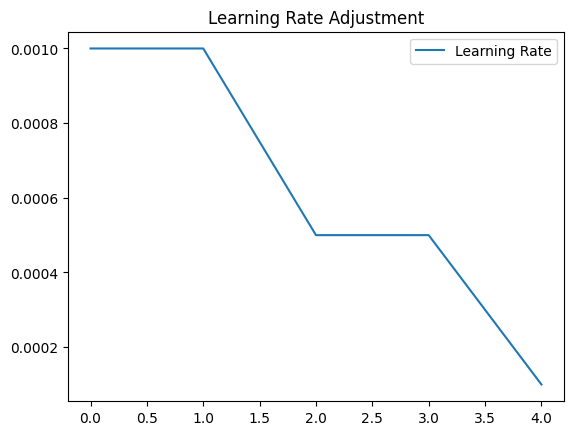

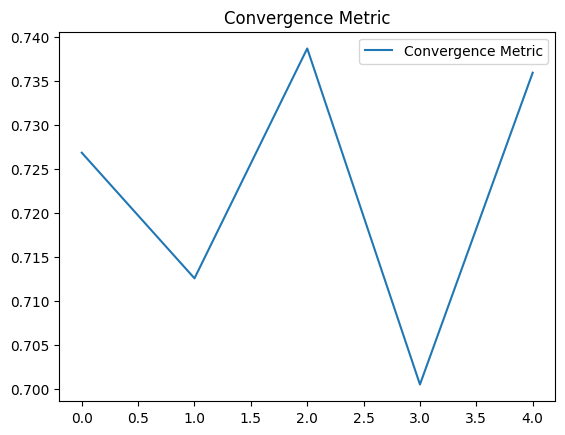

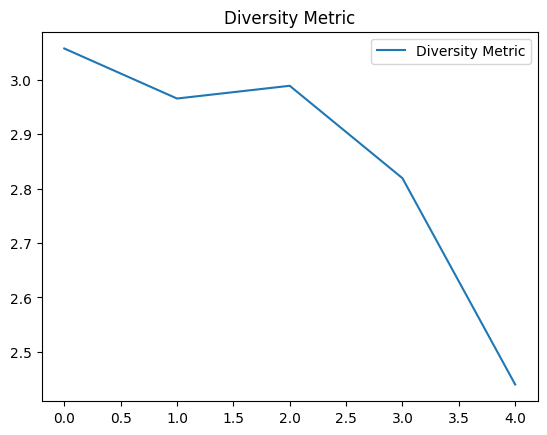

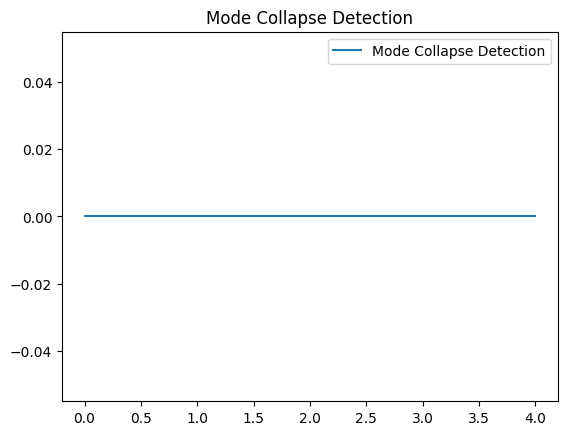

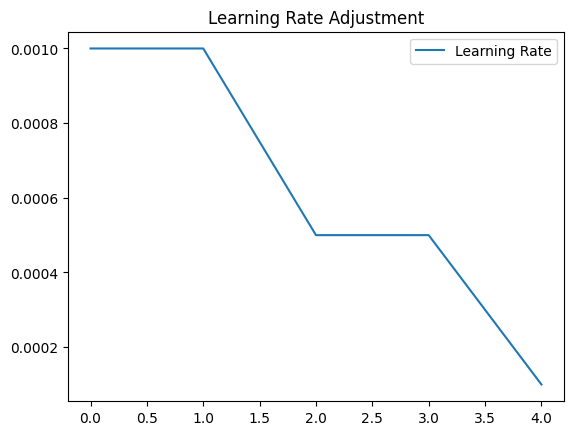

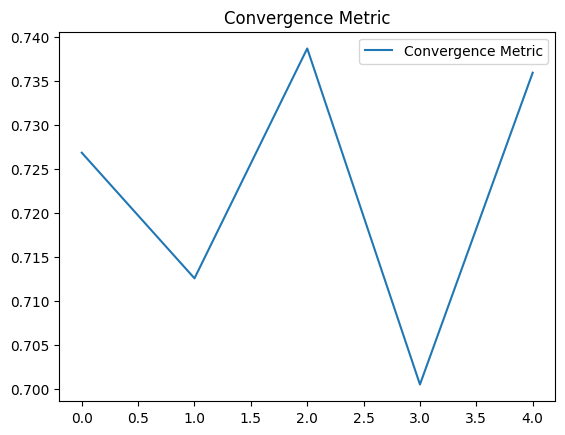

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from numpy.random import randn
import csv

# Define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# Define the combined generator and discriminator model
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Generate n real samples with class labels
def generate_real_samples(n):
    X1 = randn(n) - 0.5
    X2 = X1 * X1
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.ones((n, 1))
    return X, y

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    x_input = randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# Use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    return X, y

def plot_generated_samples(generator, latent_dim, n=100):
    x_fake = generate_latent_points(latent_dim, n)
    generated_samples = generator.predict(x_fake)

    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], color='green', alpha=0.8)
    plt.title('Generated Samples')
    plt.show()

def plot_discriminator_and_generator_losses(d_losses_real, d_losses_fake, g_losses):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(d_losses_real, label='Discriminator Loss Real')
    plt.plot(d_losses_fake, label='Discriminator Loss Fake')
    plt.title('Discriminator Losses')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Generator Loss')
    plt.legend()

    plt.show()

def diversity_metric(generated_samples):
    return np.var(generated_samples)

def mode_collapse_detection(generated_samples):
    # Simple mode collapse detection based on variance
    return np.var(generated_samples) < 0.1

def learning_rate_adjustment(epoch):
    if epoch < 5000:
        return 0.001
    elif epoch < 8000:
        return 0.0005
    else:
        return 0.0001

def convergence_metric(d_loss_real, d_loss_fake, g_loss):
    return abs(d_loss_real - d_loss_fake) + g_loss


def plot_diversity(diversity_metrics):
    plt.plot(diversity_metrics, label='Diversity Metric')
    plt.title('Diversity Metric')
    plt.legend()
    plt.show()

def plot_mode_collapse(mode_collapse_flags):
    plt.plot(mode_collapse_flags, label='Mode Collapse Detection')
    plt.title('Mode Collapse Detection')
    plt.legend()
    plt.show()

def plot_learning_rates(learning_rates):
    plt.plot(learning_rates, label='Learning Rate')
    plt.title('Learning Rate Adjustment')
    plt.legend()
    plt.show()

def plot_convergence(convergence_metrics):
    plt.plot(convergence_metrics, label='Convergence Metric')
    plt.title('Convergence Metric')
    plt.legend()
    plt.show()

# Define a hypothetical function for generating function data
def some_function(epoch):
    # Replace this with your actual function logic
    # return 2 * epoch + 5            #linear growth
    # return 2 ** epoch               #exponential growth
    # return 10 * np.sin(epoch / 10)  #sine wave oscillation
    return epoch * 10

def train_with_metrics(d_model, g_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000, save_interval=1000):
    half_batch = int(n_batch / 2)
    d_losses_real, d_losses_fake, g_losses = [], [], []

    diversity_metrics = []
    mode_collapse_flags = []
    learning_rates = []
    convergence_metrics = []

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Learning rate schedule callback
    def lr_schedule(epoch):
        lr = 0.001
        if epoch > 5000:
            lr = 0.0005
        if epoch > 8000:
            lr = 0.0001
        return lr

    lr_scheduler = LearningRateScheduler(lr_schedule)

    for i in range(n_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        X_combined = np.vstack((X_real, X_fake))
        y_combined = np.vstack((y_real, y_fake))
        d_loss_real = d_model.train_on_batch(X_real, y_real)[0]  # Extracting the loss value
        d_loss_fake = d_model.train_on_batch(X_fake, y_fake)[0]  # Extracting the loss value
        d_loss_combined = d_model.train_on_batch(X_combined, y_combined)[0]  # Extracting the loss value

        X_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)[0]  # Extracting the loss value

        d_losses_real.append(d_loss_real)
        d_losses_fake.append(d_loss_fake)
        g_losses.append(g_loss)

        if (i+1) % n_eval == 0:
            X_real_eval, y_real_eval = generate_real_samples(1000)
            _, acc_real = d_model.evaluate(X_real_eval, y_real_eval, verbose=0)
            X_fake_eval, y_fake_eval = generate_fake_samples(g_model, latent_dim, 1000)
            _, acc_fake = d_model.evaluate(X_fake_eval, y_fake_eval, verbose=0)
            print(f"Discriminator Accuracy Real: {acc_real*100:.2f}%, Fake: {acc_fake*100:.2f}%")

            X_gan_eval = generate_latent_points(latent_dim, 1000)
            y_gan_eval = np.ones((1000, 1))
            acc_gan = gan_model.evaluate(X_gan_eval, y_gan_eval, verbose=0)
            if isinstance(acc_gan, list):
                acc_gan = acc_gan[-1]
            print(f"Generator Accuracy: {acc_gan*100:.2f}%")

            # Plot generated samples
            plot_generated_samples(g_model, latent_dim)

            # Plot discriminator and generator losses
            plot_discriminator_and_generator_losses(d_losses_real, d_losses_fake, g_losses)

            # Calculate diversity metric
            diversity = diversity_metric(X_fake_eval)
            diversity_metrics.append(diversity)

            # Detect mode collapse
            mode_collapse = mode_collapse_detection(X_fake_eval)
            mode_collapse_flags.append(mode_collapse)

            # Adjust learning rate dynamically
            lr = learning_rate_adjustment(i)
            learning_rates.append(lr)
            opt = Adam(learning_rate=lr, beta_1=0.5)  # Fixing the lr parameter
            gan_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

            # Calculate convergence metric
            convergence = convergence_metric(d_loss_real, d_loss_fake, g_loss)
            convergence_metrics.append(convergence)


    # Open a CSV file for writing the results
    with open('training_results_2D.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(['Epoch', 'D Loss Real', 'D Loss Fake', 'G Loss', 'D Accuracy Real', 'D Accuracy Fake', 'G Accuracy', 'Diversity', 'Mode Collapse', 'Learning Rate', 'Convergence', 'Function Data'])

        for i in range(n_epochs):
            # ... (unchanged code)

            if (i+1) % n_eval == 0:
                # ... (unchanged code)

                # Hypothetical function data
                function_data = some_function(i)

                # Write results to the CSV file
                writer.writerow([i+1, d_loss_real, d_loss_fake, g_loss, acc_real, acc_fake, acc_gan, diversity, mode_collapse, lr, convergence, function_data])

                # Save models every save_interval epochs
                if (i+1) % save_interval == 0:
                    g_model.save(f'generator_model_epoch_{i+1}.h5')
                    d_model.save(f'discriminator_model_epoch_{i+1}.h5')
                    gan_model.save(f'gan_model_epoch_{i+1}.h5')

                    # Plot graphs
                    plot_diversity(diversity_metrics)
                    plot_mode_collapse(mode_collapse_flags)
                    plot_learning_rates(learning_rates)
                    plot_convergence(convergence_metrics)

    # Save the final models
    g_model.save('generator_model_final.h5')
    d_model.save('discriminator_model_final.h5')
    gan_model.save('gan_model_final.h5')

    return g_model

# Train model
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
trained_generator = train_with_metrics(discriminator, generator, gan_model, latent_dim, save_interval=500)

3D Function Generation

32/32 [==============================] - 0s 2ms/step
Discriminator Accuracy Real: 29.80%, Fake: 69.30%
Generator Accuracy: 32.20%
4/4 [==============================] - 0s 4ms/step


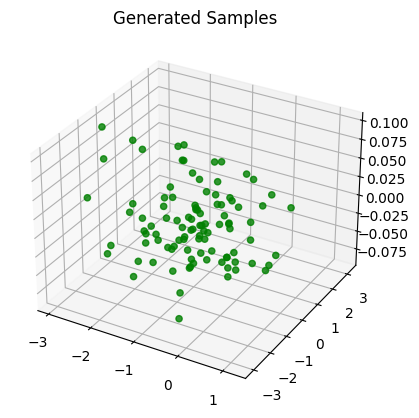

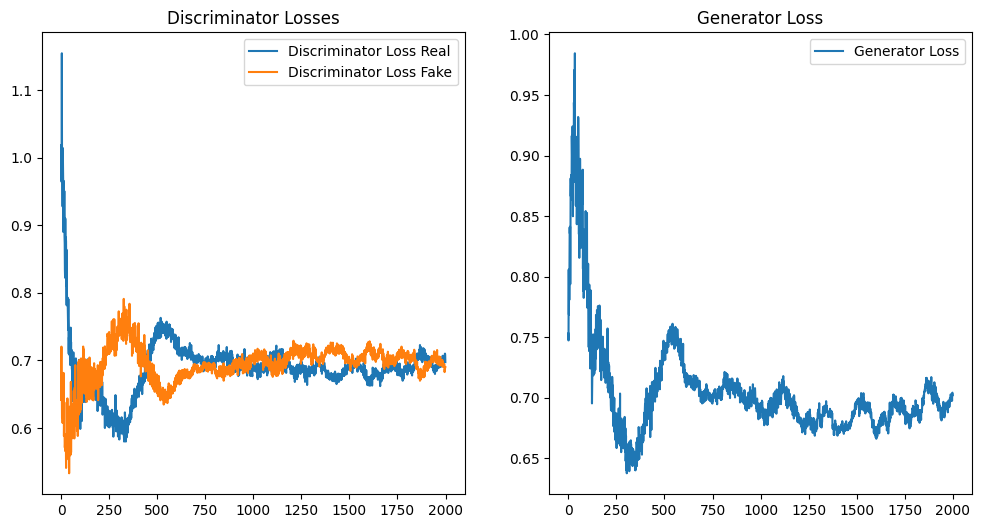

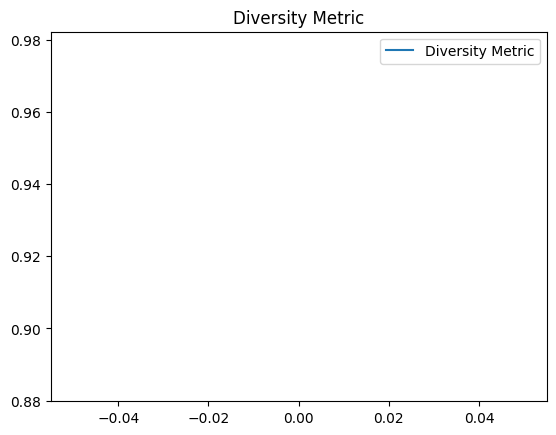

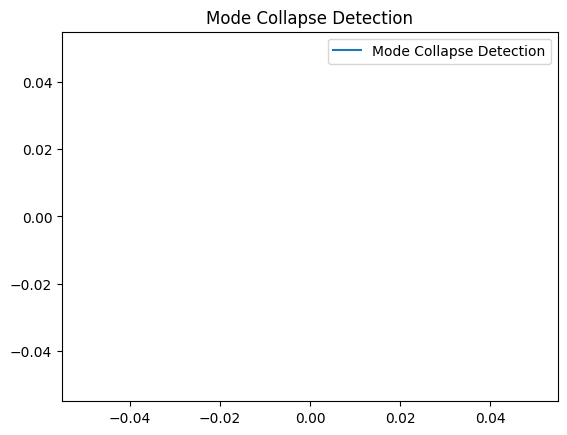

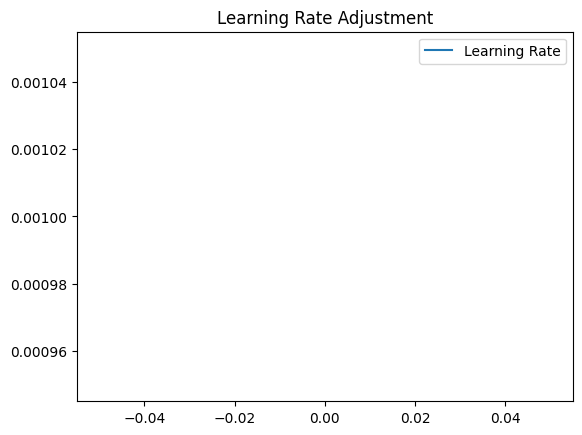

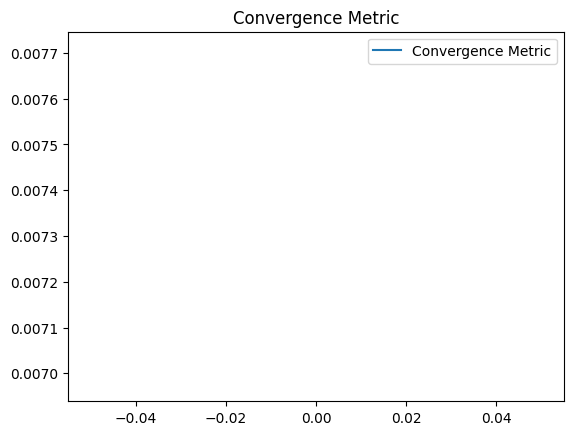

32/32 [==============================] - 0s 2ms/step
Discriminator Accuracy Real: 63.70%, Fake: 37.70%
Generator Accuracy: 63.70%
4/4 [==============================] - 0s 5ms/step


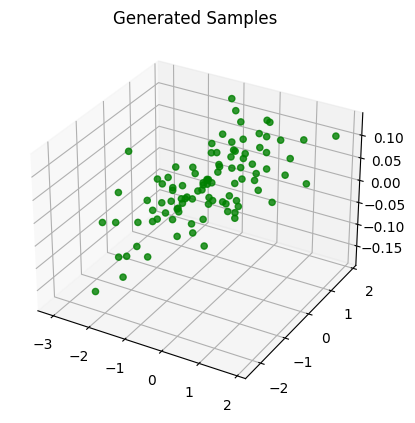

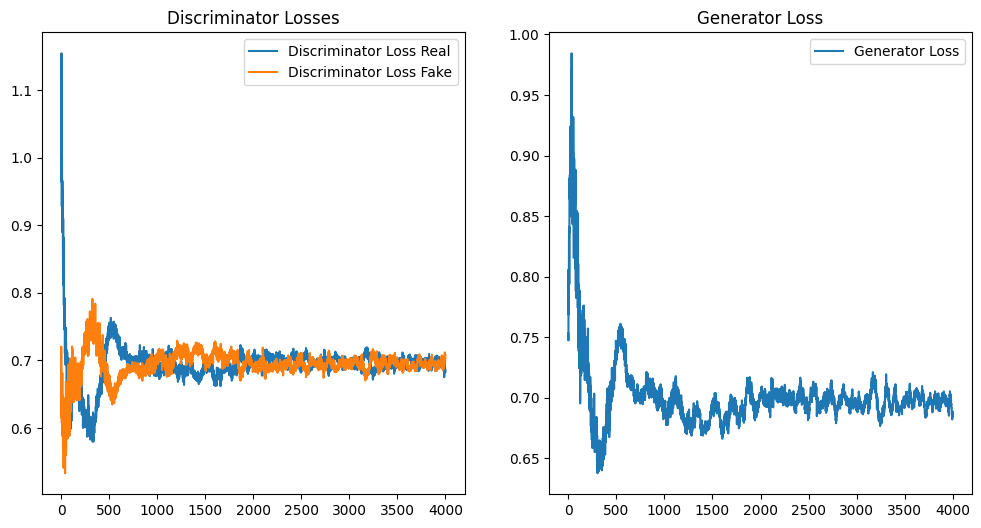

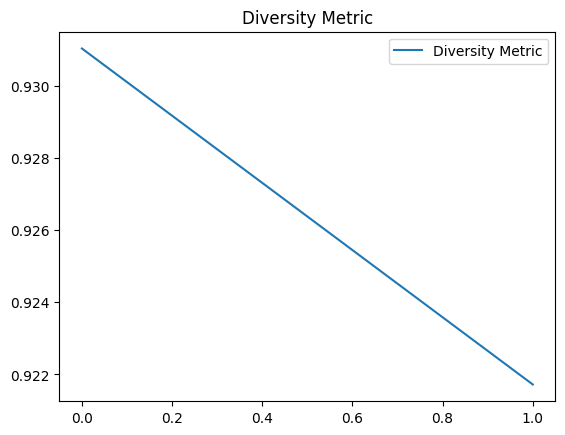

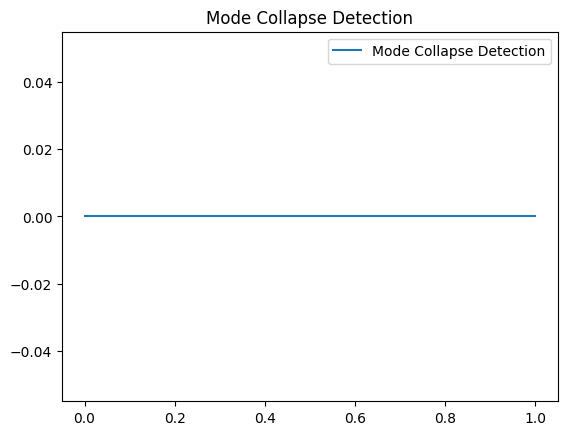

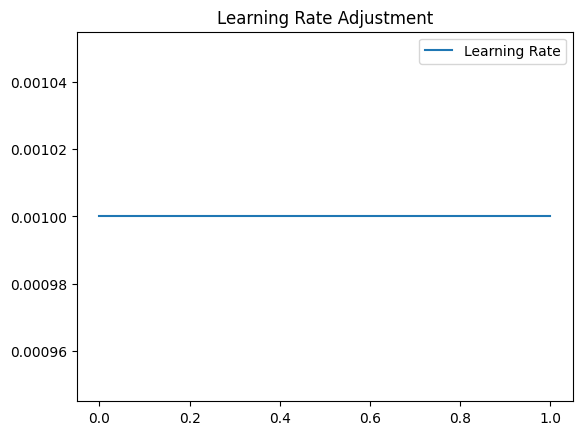

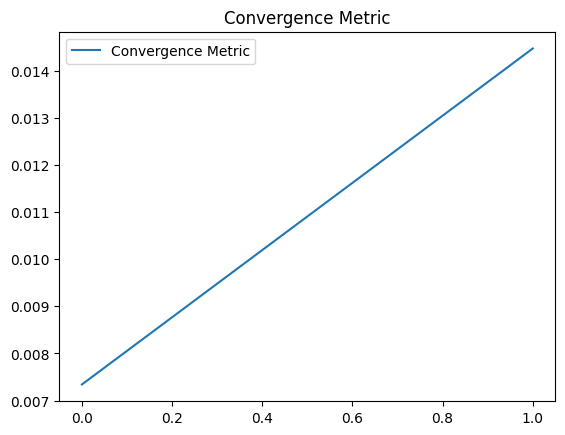

32/32 [==============================] - 0s 2ms/step
Discriminator Accuracy Real: 39.10%, Fake: 57.90%
Generator Accuracy: 43.20%
4/4 [==============================] - 0s 3ms/step


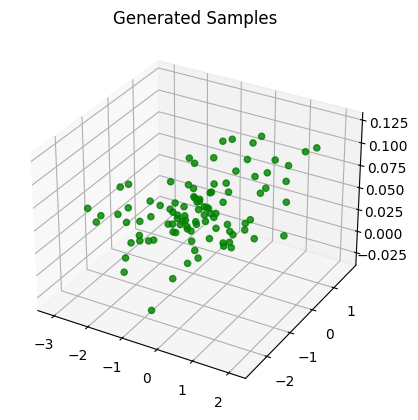

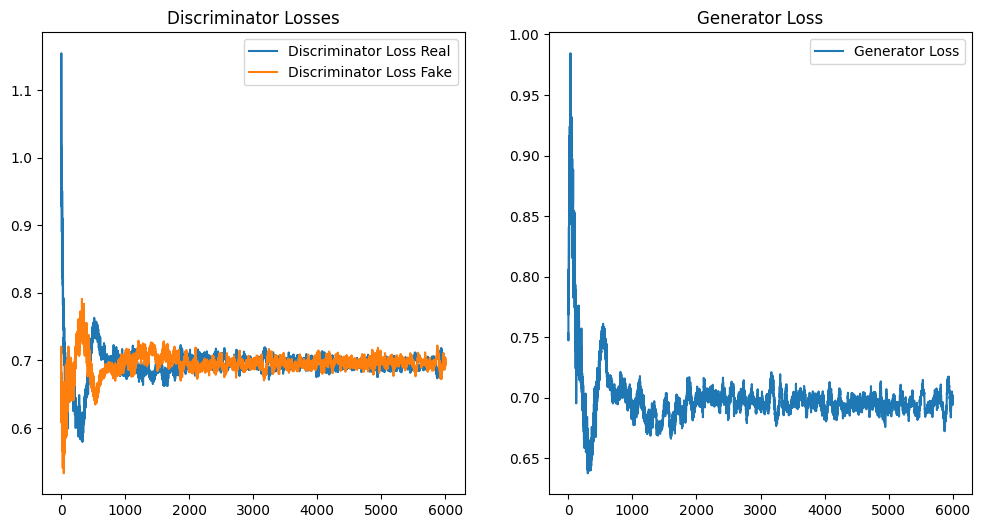

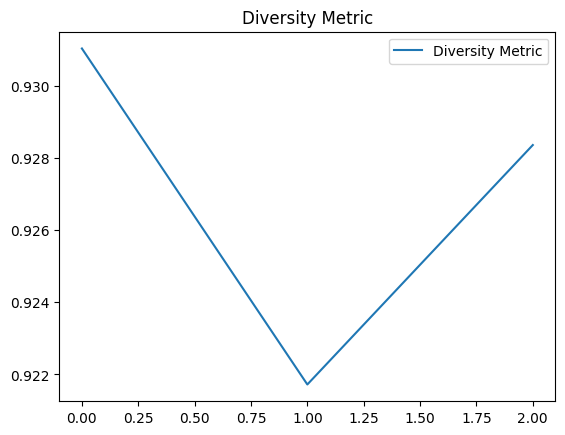

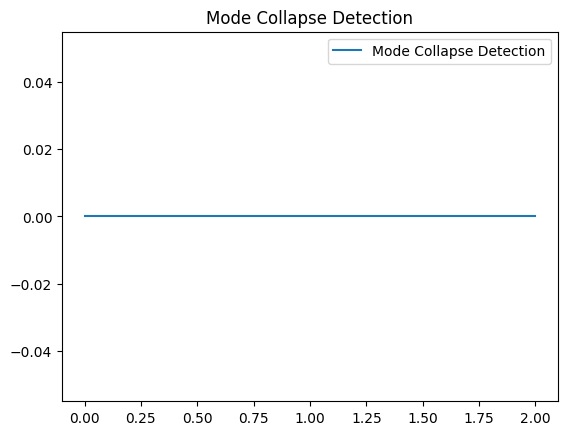

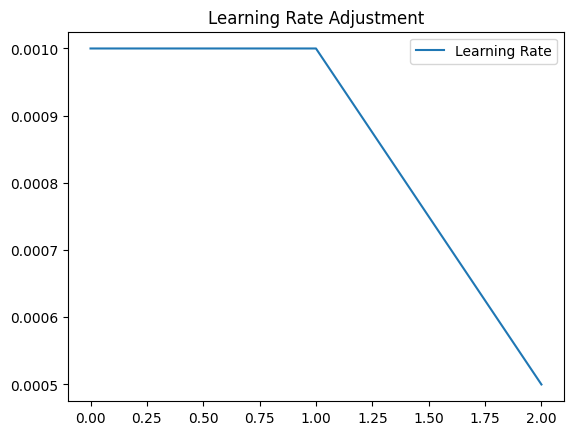

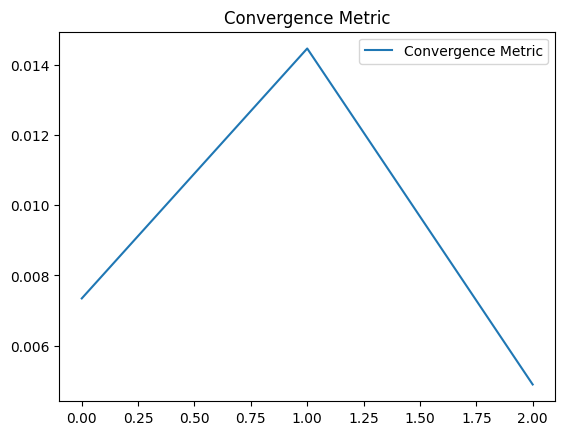

32/32 [==============================] - 0s 2ms/step
Discriminator Accuracy Real: 51.90%, Fake: 48.80%
Generator Accuracy: 52.10%
4/4 [==============================] - 0s 3ms/step


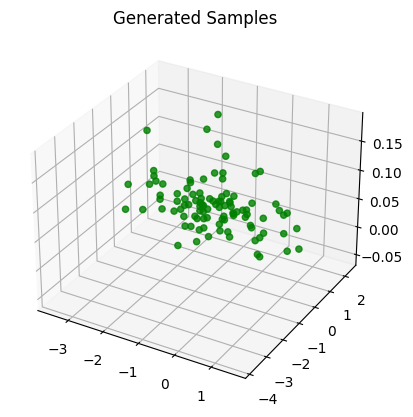

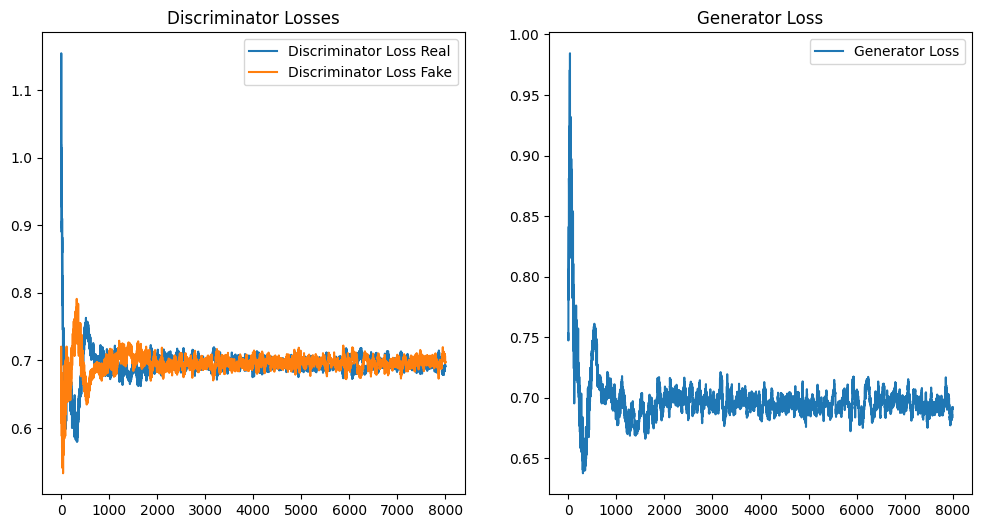

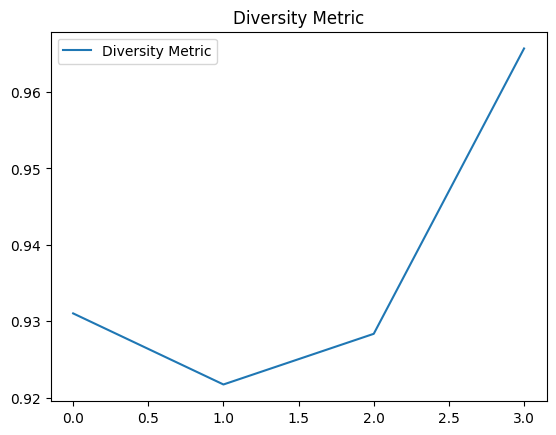

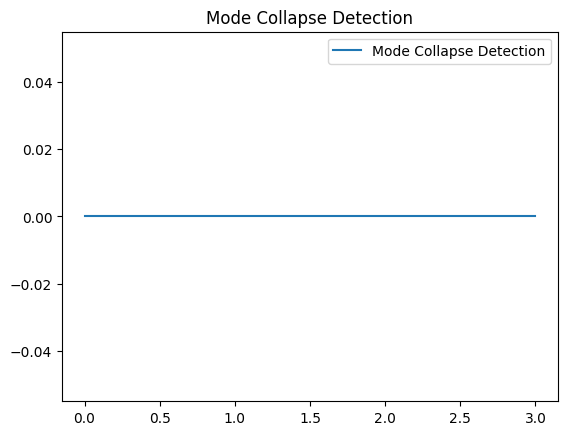

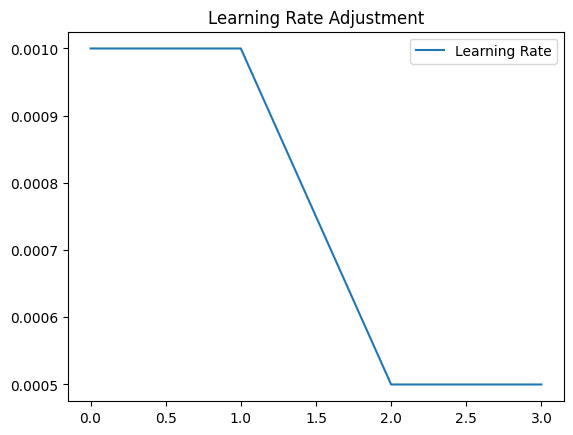

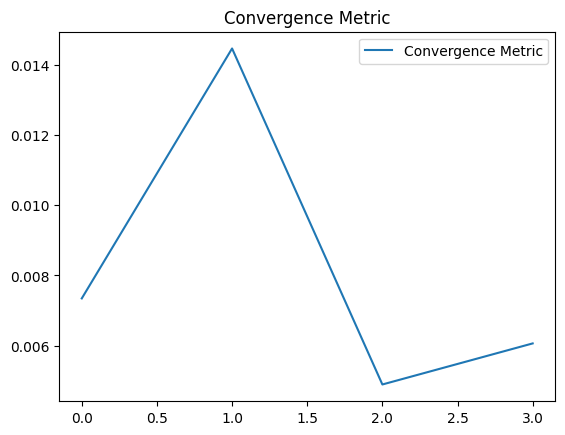

32/32 [==============================] - 0s 2ms/step
Discriminator Accuracy Real: 41.20%, Fake: 48.40%
Generator Accuracy: 49.90%
4/4 [==============================] - 0s 3ms/step


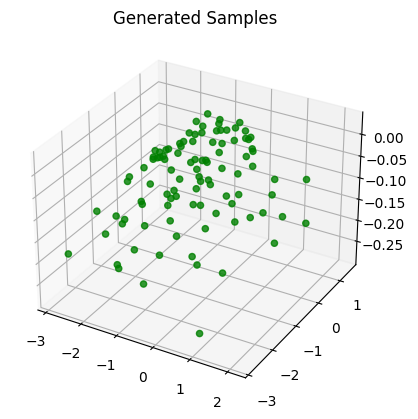

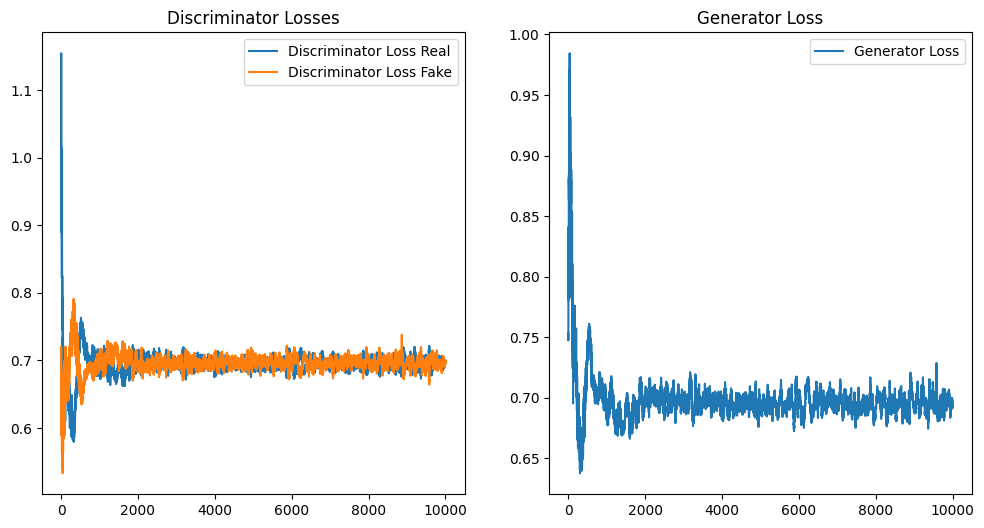

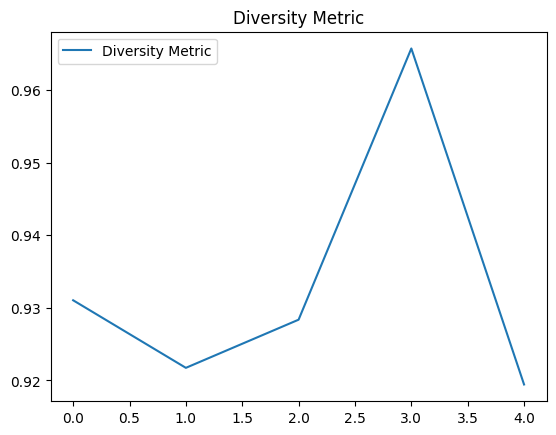

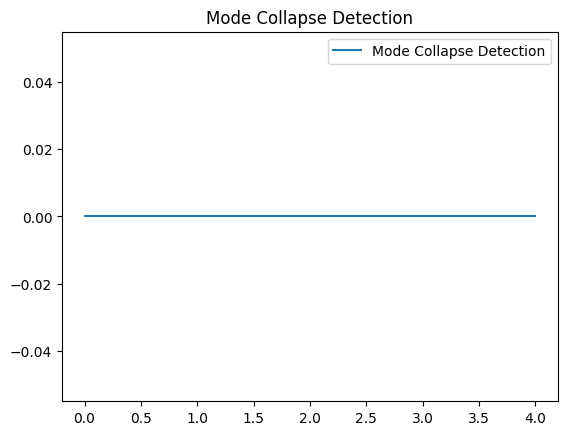

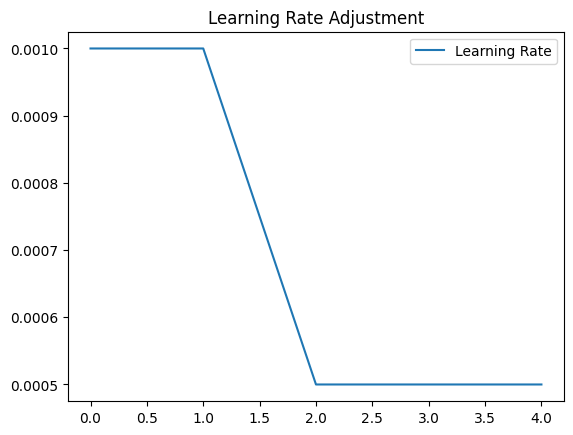

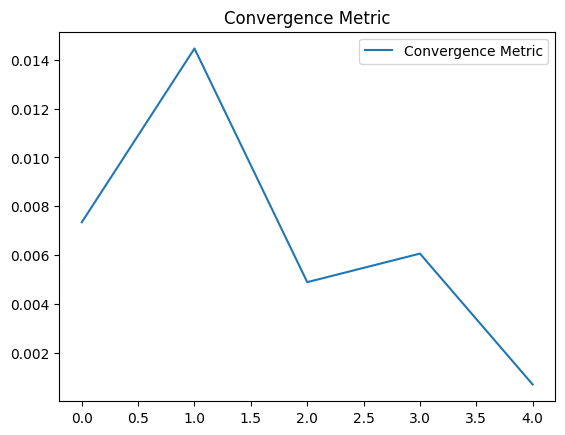

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from numpy.random import randn
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

# Define the standalone discriminator model
def define_discriminator(n_inputs=3):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define the standalone generator model
def define_generator(latent_dim, n_outputs=3):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# Define the combined generator and discriminator model
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Generate n real samples with class labels
def generate_real_samples(n):
    X1 = randn(n) - 0.5
    X2 = randn(n) - 0.5
    X3 = np.sin(10 * (X1**2 + X2**2)) / 10  # function definition
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X3 = X3.reshape(n, 1)
    X = np.hstack((X1, X2, X3))
    y = np.ones((n, 1))
    return X, y

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    x_input = randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# Use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    return X, y

def plot_generated_samples(generator, latent_dim, n=100):
    x_fake = generate_latent_points(latent_dim, n)
    generated_samples = generator.predict(x_fake)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], color='green', alpha=0.8)
    ax.set_title('Generated Samples')
    plt.show()

def plot_discriminator_and_generator_losses(d_losses_real, d_losses_fake, g_losses):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(d_losses_real, label='Discriminator Loss Real')
    plt.plot(d_losses_fake, label='Discriminator Loss Fake')
    plt.title('Discriminator Losses')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Generator Loss')
    plt.legend()

    plt.show()
# Function to calculate diversity metric
def diversity_metric(samples):
    # Calculate the standard deviation of pairwise distances between samples
    pairwise_distances = np.linalg.norm(samples - samples[:, np.newaxis], axis=-1)
    diversity_value = np.std(pairwise_distances)
    return diversity_value

# Function to detect mode collapse (simple example)
def mode_collapse_detection(samples):
    # Calculate the standard deviation of the generated samples
    std_dev = np.std(samples)
    # You might have a more sophisticated mode collapse detection method
    # This is just a simple example
    return std_dev < 0.1  # Adjust the threshold as needed

# Function to adjust learning rate dynamically
def learning_rate_adjustment(epoch):
    # Adjust learning rate based on the current epoch
    if epoch > 5000:
        return 0.0005
    elif epoch > 8000:
        return 0.0001
    else:
        return 0.001

# Function to calculate convergence metric (simple example)
def convergence_metric(d_loss_real, d_loss_fake, g_loss):
    # Calculate the difference between real and fake discriminator losses
    diff_loss = np.abs(d_loss_real - d_loss_fake)
    # You might have a more sophisticated convergence metric
    # This is just a simple example
    return diff_loss

def plot_diversity(diversity_metrics):
    plt.plot(diversity_metrics, label='Diversity Metric')
    plt.title('Diversity Metric')
    plt.legend()
    plt.show()

def plot_mode_collapse(mode_collapse_flags):
    plt.plot(mode_collapse_flags, label='Mode Collapse Detection')
    plt.title('Mode Collapse Detection')
    plt.legend()
    plt.show()

def plot_learning_rates(learning_rates):
    plt.plot(learning_rates, label='Learning Rate')
    plt.title('Learning Rate Adjustment')
    plt.legend()
    plt.show()

def plot_convergence(convergence_metrics):
    plt.plot(convergence_metrics, label='Convergence Metric')
    plt.title('Convergence Metric')
    plt.legend()
    plt.show()

def train_with_metrics_and_save_csv(d_model, g_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000, save_interval=1000, csv_filename='training_results_3D.csv', csv_save_interval=100):
    half_batch = int(n_batch / 2)
    d_losses_real, d_losses_fake, g_losses = [], [], []

    diversity_metrics = []
    mode_collapse_flags = []
    learning_rates = []
    convergence_metrics = []

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Learning rate schedule callback
    def lr_schedule(epoch):
        lr = 0.001
        if epoch > 5000:
            lr = 0.0005
        if epoch > 8000:
            lr = 0.0001
        return lr

    lr_scheduler = LearningRateScheduler(lr_schedule)

    for i in range(n_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        X_combined = np.vstack((X_real, X_fake))
        y_combined = np.vstack((y_real, y_fake))
        d_loss_real = d_model.train_on_batch(X_real, y_real)[0]  # Extracting the loss value
        d_loss_fake = d_model.train_on_batch(X_fake, y_fake)[0]  # Extracting the loss value
        d_loss_combined = d_model.train_on_batch(X_combined, y_combined)[0]  # Extracting the loss value

        X_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)[0]  # Extracting the loss value

        d_losses_real.append(d_loss_real)
        d_losses_fake.append(d_loss_fake)
        g_losses.append(g_loss)

        if (i+1) % n_eval == 0:
            X_real_eval, y_real_eval = generate_real_samples(1000)
            _, acc_real = d_model.evaluate(X_real_eval, y_real_eval, verbose=0)
            X_fake_eval, y_fake_eval = generate_fake_samples(g_model, latent_dim, 1000)
            _, acc_fake = d_model.evaluate(X_fake_eval, y_fake_eval, verbose=0)
            print(f"Discriminator Accuracy Real: {acc_real*100:.2f}%, Fake: {acc_fake*100:.2f}%")

            X_gan_eval = generate_latent_points(latent_dim, 1000)
            y_gan_eval = np.ones((1000, 1))
            acc_gan = gan_model.evaluate(X_gan_eval, y_gan_eval, verbose=0)
            if isinstance(acc_gan, list):
                acc_gan = acc_gan[-1]
            print(f"Generator Accuracy: {acc_gan*100:.2f}%")

            # Plot generated samples
            plot_generated_samples(g_model, latent_dim)

            # Plot discriminator and generator losses
            plot_discriminator_and_generator_losses(d_losses_real, d_losses_fake, g_losses)

            # Calculate diversity metric
            diversity = diversity_metric(X_fake_eval)
            diversity_metrics.append(diversity)

            # Detect mode collapse
            mode_collapse = mode_collapse_detection(X_fake_eval)
            mode_collapse_flags.append(mode_collapse)

            # Adjust learning rate dynamically
            lr = learning_rate_adjustment(i)
            learning_rates.append(lr)
            opt = Adam(learning_rate=lr, beta_1=0.5)  # Fixing the lr parameter
            gan_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

            # Calculate convergence metric
            convergence = convergence_metric(d_loss_real, d_loss_fake, g_loss)
            convergence_metrics.append(convergence)

            # Plot additional metrics
            plot_diversity(diversity_metrics)
            plot_mode_collapse(mode_collapse_flags)
            plot_learning_rates(learning_rates)
            plot_convergence(convergence_metrics)


    # Save the generator model
    g_model.save('generator_model.h5')

    # Optionally, you can also save the discriminator and GAN models if needed
    d_model.save('discriminator_model.h5')
    gan_model.save('gan_model.h5')

    # Open a CSV file for writing
    with open('training_results_3D.csv', 'w', newline='') as csvfile:
        fieldnames = ['Epoch', 'D Loss Real', 'D Loss Fake', 'G Loss', 'D Accuracy Real', 'D Accuracy Fake', 'G Accuracy', 'Diversity', 'Mode Collapse', 'Learning Rate', 'Convergence']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header
        writer.writeheader()

        for i in range(n_epochs):
            # ... (rest of the code remains the same)

            # Check if the current epoch is a multiple of csv_save_interval
            if (i + 1) % csv_save_interval == 0:
                # Write metrics to CSV file
                writer.writerow({'Epoch': i + 1, 'D Loss Real': d_loss_real, 'D Loss Fake': d_loss_fake, 'G Loss': g_loss, 'D Accuracy Real': acc_real, 'D Accuracy Fake': acc_fake, 'G Accuracy': acc_gan, 'Diversity': diversity, 'Mode Collapse': mode_collapse, 'Learning Rate': lr, 'Convergence': convergence})

    # Save the generator model and other models
    g_model.save('generator_model.h5')
    d_model.save('discriminator_model.h5')
    gan_model.save('gan_model.h5')

    return g_model

    # Train model and save metrics to CSV file after every 100 epochs
    trained_generator = train_with_metrics_and_save_csv(discriminator, generator, gan_model, latent_dim, save_interval=500, csv_save_interval=100)

# Train model
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
trained_generator = train_with_metrics_and_save_csv(discriminator, generator, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000, save_interval=500, csv_filename='gan_metrics.csv', csv_save_interval=100)
